# 04. PyTorch custom datasets notebook

You have used some datasets in PyTorch before.

But how to get your own data into PyTorch?

One of the ways to do so is via custom datasets.

## Domain Libraries

Depending on what you are working on, vision, text, audio, recommendations, you will want to look into different PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device agnostic code.

In [1]:
import torch

from torch import nn

torch.__version__

'2.4.0'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Fri Jul 26 05:13:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   69C    P0             25W /   80W |    1969MiB /   6144MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 1 00/0 of the images (75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup a path to the data folder
data_path = Path("food_data/")
img_path = data_path / "pizza_steak_sushi"

# If the image path exists, we do not want to download it. If it does not exist, we want to download it.
if img_path.is_dir():
    # we do not want to download the data
    print(f"{img_path} directory already exists...... Skipping download.")
else:
    # We want to download the data
    print(f"{img_path} directory does not exist. Creating the directory.")
    img_path.mkdir(parents=True, exist_ok=True)
    

# Downloading
with open(data_path / "pizza_steak_sushi.zip" , "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data....")
    f.write(request.content)

# Extracting data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip" , "r") as zip_ref:
    print(f"Extracting pizza, steak, sushi data to {img_path}")
    zip_ref.extractall(img_path)


food_data\pizza_steak_sushi directory already exists...... Skipping download.
Extracting pizza, steak, sushi data to food_data\pizza_steak_sushi


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(img_path)

There are 2 directories and 0 images in 'food_data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'food_data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'food_data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'food_data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'food_data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'food_data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'food_data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'food_data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'food_data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup training and testing directories
train_dir = img_path / "train"
test_dir = img_path / "test"

print(train_dir)
print(test_dir)

food_data\pizza_steak_sushi\train
food_data\pizza_steak_sushi\test


### 2.1 Visualizing the images

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

food_data\pizza_steak_sushi\train\sushi\3107839.jpg
sushi
Image Path : food_data\pizza_steak_sushi\train\sushi\3107839.jpg
Image Class : sushi
Image Size : (512, 384)
Image Height : 384
Iamge Width : 512


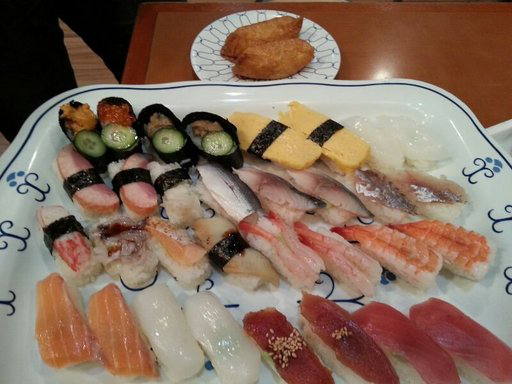

In [8]:
import random
from PIL import Image

# Set random seed
#random.seed(42)

# 1. Getting all the images
img_path_list = list(img_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(img_path_list)
print(random_image_path)

# 3. Get the class name
class_name = random_image_path.parent.stem
print(class_name)

# 4. Open the image
img = Image.open(random_image_path)

# 5. Print the metadata
print(f"Image Path : {random_image_path}")
print(f"Image Class : {class_name}")
print(f"Image Size : {img.size}")
print(f"Image Height : {img.height}")
print(f"Iamge Width : {img.width}")

img

(-0.5, 511.5, 383.5, -0.5)

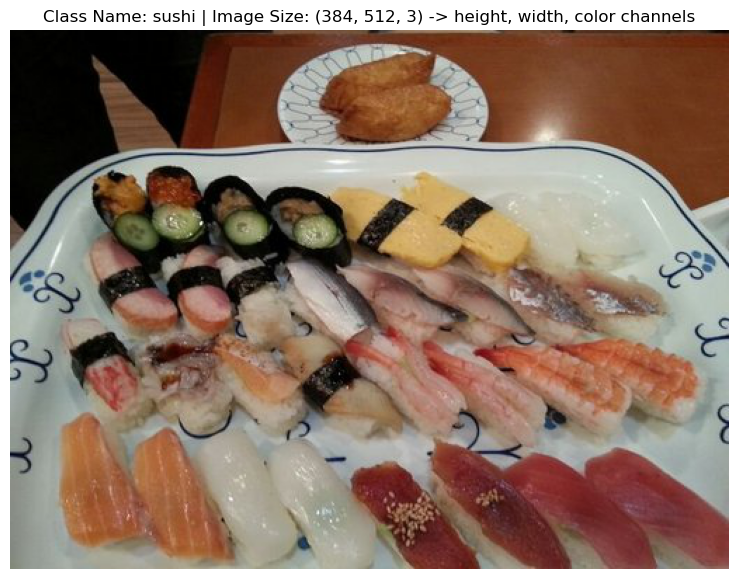

In [9]:
# Visualizing image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Class Name: {class_name} | Image Size: {img_as_array.shape} -> height, width, color channels")
plt.axis(False)

In [10]:
img_as_array

array([[[  4,   4,   2],
        [  4,   4,   2],
        [  4,   4,   2],
        ...,
        [ 13,   2,   0],
        [ 16,   5,   0],
        [ 18,   7,   1]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [ 21,   4,   0],
        [ 24,   7,   0],
        [ 26,   9,   1]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [ 59,  31,  20],
        [ 60,  32,  21],
        [ 62,  34,  23]],

       ...,

       [[130, 137, 121],
        [130, 137, 121],
        [132, 138, 124],
        ...,
        [140,  90,  83],
        [138,  89,  84],
        [138,  89,  84]],

       [[130, 137, 121],
        [131, 138, 122],
        [132, 139, 123],
        ...,
        [144, 100,  91],
        [144,  99,  93],
        [144,  99,  93]],

       [[131, 138, 122],
        [131, 138, 122],
        [133, 140, 124],
        ...,
        [151, 108,  99],
        [151, 108, 101],
        [150, 110, 102]]

## 3. Transforming data
Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images) .
2. Turn it into a `torch.utils.data.Dataset` and subsequently in a `torch.utils.data.DataLoader`, we will call these `Dataset` and `Dataloader`.

In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

### 3.1 Transforming the data with `torchvision.transforms`

In [12]:
# Write a tranform for image data
data_transform = transforms.Compose([
    # Resize the image in 64 x 64 shape
    transforms.Resize(size=(64,64)),
    # Flip the image on horizontal axis based on probability
    transforms.RandomHorizontalFlip(p=0.5),
    # transform the images to tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img).dtype

torch.float32

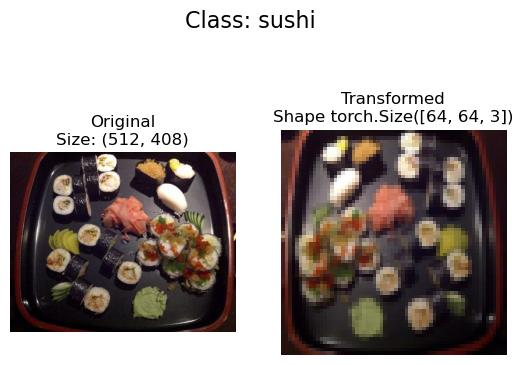

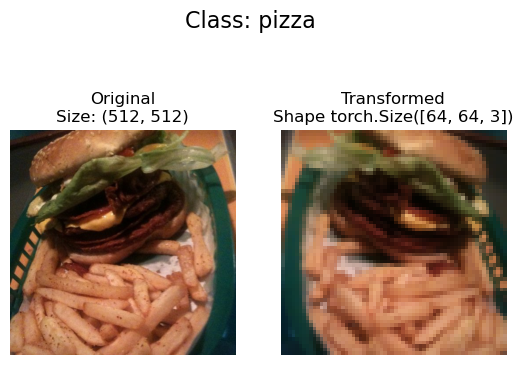

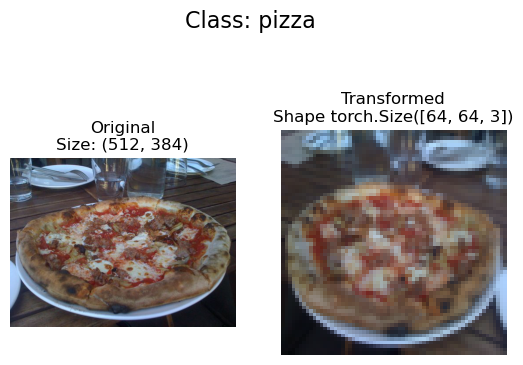

In [14]:
def plot_transformed_images(image_paths: list, transform, n = 3, random_seed = None):
    """
    Selects random images from a list of path of images, and then loads/transforms them, then transforms them then plots the original vs the transformed version.
    """

    if random_seed:
        random.seed(random_seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # note we will need to chane shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths=img_path_list, transform=data_transform, n=3, random_seed=42)

## 4 Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform= data_transform,
                                  target_transform= None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [16]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: food_data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: food_data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(WindowsPath('food_data/pizza_steak_sushi/train'),
 WindowsPath('food_data/pizza_steak_sushi/test'))

In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# Get class names as dictionaries
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('food_data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [22]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Label: {label}")
print(f"Label Datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original Shape: torch.Size([3, 64, 64]) -> color channels, height, width
Permuted shape torch.Size([64, 64, 3]) -> height, width, color channels


(-0.5, 63.5, 63.5, -0.5)

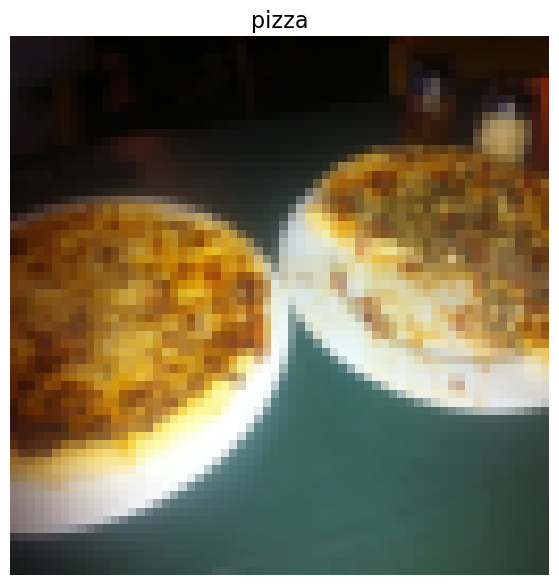

In [23]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original Shape: {img.shape} -> color channels, height, width")
print(f"Permuted shape {img_permute.shape} -> height, width, color channels")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize = 16)
plt.axis(False)

### 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size`s our model can see `batch_size` images at a time.

In [24]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [25]:
# Let's check out what we have created
print(f"DataLoaders: \n{train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

DataLoaders: 
(<torch.utils.data.dataloader.DataLoader object at 0x000001B8D0617550>, <torch.utils.data.dataloader.DataLoader object at 0x000001B8DCE1ABC0>)
Length of train dataloader: 225
Length of test dataloader: 75


In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch size, color channels, height, width]")
print(f"Label Shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch size, color channels, height, width]
Label Shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load the images from file
2. want to be able to get classnames from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `dataset` out of almost anything, it doesn't mean it will work.....
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [27]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names are not found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [29]:
# Setup path for target directory

target_directory = train_dir
print(f"Target Dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: food_data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[list[str],Dict[str,int]]:
    """Finds the class folder names in the target directory."""
    # 1. Get the class names by scanning the target dictionary
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure.")
    
    # 3. Create a dictionary of index labels (computer prefer number rather than strings as a label)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [32]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self,
                targ_dir: str,
                transform= None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_img(self, index: int) -> Image.Image:
        """ Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X,y)"""
        img = self.load_img(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # Return data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [33]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size= (64, 64)),
    transforms.ToTensor()
])

In [34]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform= train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)


In [35]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1b8dcee3460>,
 <__main__.ImageFolderCustom at 0x1b8dcee1b70>)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
len(test_data), len(test_data_custom)

(75, 75)

In [38]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# Check for equality between between original imageFolder dataset and ImageFolderCustom dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to disply random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the disply getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).


In [40]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n : int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust disply if n is too high
    if n > 10:
        n = 10
        display_shape= False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set the random see
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k= n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random index and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # [C,H,W] -> [H,W,C]

        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


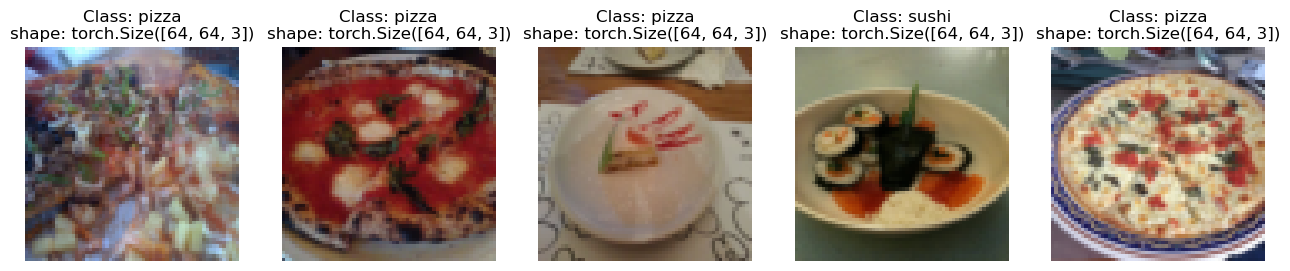

In [41]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n= 5,
                      classes=class_names,
                      seed = None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


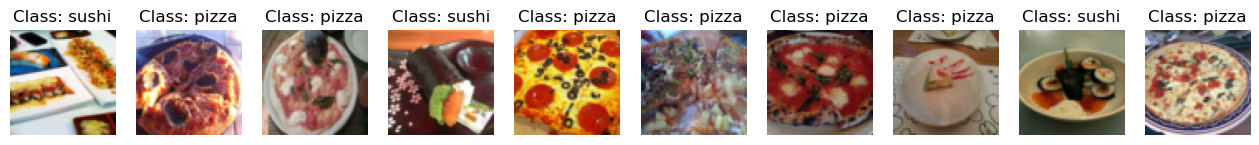

In [42]:
# Display random images from the ImageFolderCustom created Dataset
display_random_images(train_data_custom,
                      n= 20,
                      classes=class_names,
                      seed = 42)

### 5.4 Turn custom loaded images into `DataLoader`s

In [43]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

In [44]:
# Let's check out what we have created
print(f"Custom DataLoaders: \n{train_dataloader_custom, test_dataloader_custom}")
print(f"Length of custom train dataloader: {len(train_dataloader_custom)}")
print(f"Length of custom test dataloader: {len(test_dataloader_custom)}")

Custom DataLoaders: 
(<torch.utils.data.dataloader.DataLoader object at 0x000001B8DE10B0D0>, <torch.utils.data.dataloader.DataLoader object at 0x000001B8DE187CD0>)
Length of custom train dataloader: 8
Length of custom test dataloader: 3


In [45]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img_custom.shape} -> [batch size, color channels, height, width]")
print(f"Label Shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch size, color channels, height, width]
Label Shape: torch.Size([32])


## 6. Other forms of transforms (data augmentation)

Data sugmentation is the process of artificially adding divresity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that is more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels....

In [46]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [47]:
img_path

WindowsPath('food_data/pizza_steak_sushi')

In [48]:
# Get all the image paths
image_path_list = list(img_path.glob("*/*/*.jpg"))
image_path_list

[WindowsPath('food_data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('food_data/pizza_steak_sushi/test/piz

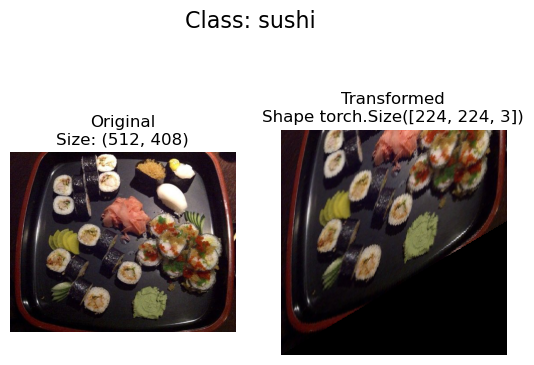

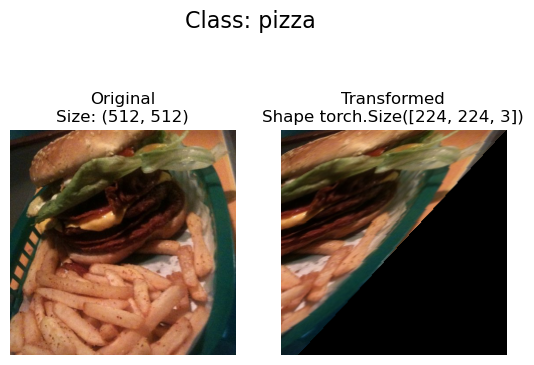

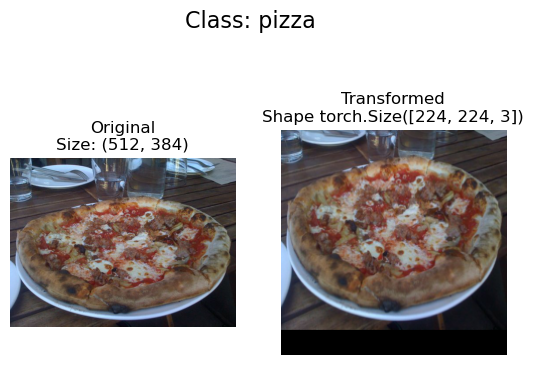

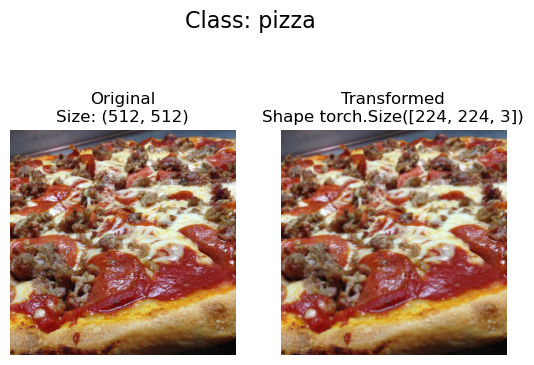

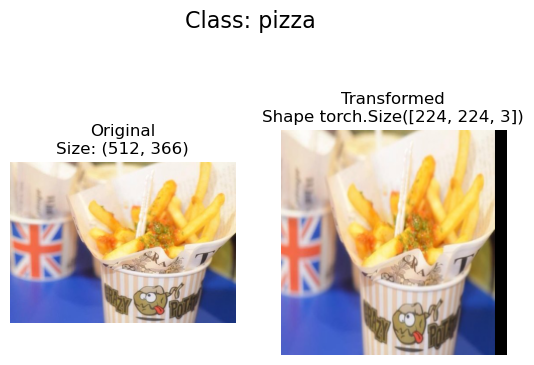

In [49]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=5,
    random_seed=42
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architechture from the CNN explainer website

### 7.1 Creating transforms and loading data for Model 0

In [50]:
# Create a simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

In [51]:
train_dir = "food_data/pizza_steak_sushi/train"
test_dir = "food_data/pizza_steak_sushi/test"

In [52]:
# Use ImageFolder to create datasets
from torchvision.datasets import ImageFolder
train_data_simple = ImageFolder(root = train_dir,
                         transform=simple_transform,
                         target_transform=None)

test_data_simple = ImageFolder(root = test_dir,
                        transform=simple_transform,
                        target_transform=None)

In [53]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_simple = DataLoader(dataset= train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers= 0,
                              shuffle= True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle= False)

In [54]:
# Let's check out what we have created
print(f"DataLoaders: \n{train_dataloader_simple, test_dataloader_simple}")
print(f"Length of train dataloader: {len(train_dataloader_simple)}")
print(f"Length of test dataloader: {len(test_dataloader_simple)}")


img, label = next(iter(train_dataloader_simple))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch size, color channels, height, width]")
print(f"Label Shape: {label.shape}")

DataLoaders: 
(<torch.utils.data.dataloader.DataLoader object at 0x000001B8DE80C730>, <torch.utils.data.dataloader.DataLoader object at 0x000001B8D6F59510>)
Length of train dataloader: 8
Length of test dataloader: 3
Image shape: torch.Size([32, 3, 256, 256]) -> [batch size, color channels, height, width]
Label Shape: torch.Size([32])


### 7.2 Creating the TinyVGG model class

And also setting up device agnostic code.

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [56]:
from torch import nn

class TinyVGGModelV0(nn.Module):
    def __init__(self, input_shape = 3, hidden_units = 128, output_shape=len(class_names)):
        super().__init__()
        self.conv_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_stack_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_stack_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*12*12,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.linear_stack(self.conv_stack_4(self.conv_stack_3(self.conv_stack_2(self.conv_stack_1(x)))))

In [57]:
torch.manual_seed(42)

model_0 = TinyVGGModelV0(input_shape=3,
                         output_shape=len(class_names),
                         hidden_units=64).to(device)

In [58]:
model_0

TinyVGGModelV0(
  (conv_stack_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
 

### 7.3 Try a forward pass on a single image (to test the model)

In [59]:
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch, label_batch = image_batch.to(device), label_batch.to(device)
image_batch, label_batch

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

In [60]:
!nvidia-smi

Fri Jul 26 05:13:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   71C    P0             26W /   80W |    2878MiB /   6144MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [61]:
# try a forward pass
model_0(image_batch)

tensor([[ 0.0495, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0665],
        [ 0.0495, -0.0621,  0.0666],
        [ 0.0493, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0620,  0.0667],
        [ 0.0494, -0.0621,  0.0667],
        [ 0.0494, -0.0621,  0.0667],
        [ 0.0495, -0.0621,  0.0666],
        [ 0.0494, -0.0620,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0667],
        [ 0.0495, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0620,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0620,  0.0666],
        [ 0.0495, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0494, -0.0621,  0.0666],
        [ 0.0493, -0.0621,  0.0666],
        [ 0.0494, -0.0622,  0.0666],
        [ 0.0494, -0.0620,  0.0666],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [62]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [63]:
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModelV0                           [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 126, 126]        --
│    └─Conv2d: 2-1                       [32, 64, 254, 254]        1,792
│    └─ReLU: 2-2                         [32, 64, 254, 254]        --
│    └─Conv2d: 2-3                       [32, 64, 252, 252]        36,928
│    └─ReLU: 2-4                         [32, 64, 252, 252]        --
│    └─MaxPool2d: 2-5                    [32, 64, 126, 126]        --
├─Sequential: 1-2                        [32, 64, 61, 61]          --
│    └─Conv2d: 2-6                       [32, 64, 124, 124]        36,928
│    └─ReLU: 2-7                         [32, 64, 124, 124]        --
│    └─Conv2d: 2-8                       [32, 64, 122, 122]        36,928
│    └─ReLU: 2-9                         [32, 64, 122, 122]        --
│    └─MaxPool2d: 2-10                   [32, 64, 61, 61]          --


### 7.5 Create train and test loops functions

* train_step() - takes in a model and dataloader and trains the model on the dataloader.
* test_step() - takes in a model and dataloader and evaluates the model on the dataloader.

In [64]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0,0

    # Loop through the dataloader
    for batch, (X,y) in enumerate(dataloader):
        # Send data to GPU
        X = X.to(device)
        y=y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss +=loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

        # Calculate Accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1),dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss /=len(dataloader)
    train_acc /= len(dataloader)

    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.5f}")

    return train_loss, train_acc


In [65]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module,
              device = device):
    model.eval()
    test_loss, test_acc= 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred_test = model(X)

            # Calculate the loss
            loss = loss_fn(y_pred_test, y)
            test_loss +=loss.item()

            # Calculate Accuracy
            y_pred_class_test = torch.argmax(torch.softmax(y_pred_test, dim = 1),dim = 1)
            test_acc += (y_pred_class_test == y).sum().item()/len(y_pred_test)

        test_loss /=len(dataloader)
        test_acc /= len(dataloader)

        print(f"Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.5f}")

        return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [66]:
import torch.utils
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss_fn

def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int =5,
          device = device):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc"  : []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out whats happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss:4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\ac253\anaconda3\envs\ARC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.7 Train and evaluate model 0

In [67]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# recreate an instance of TinyVGG
model_0 = TinyVGGModelV0(input_shape=3,
                         hidden_units=64,
                         output_shape=len(train_data.classes)).to(device)

# Set up a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total Training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Training Loss: 1.12753 | Training Accuracy: 0.25781


  2%|▏         | 1/50 [00:56<46:02, 56.37s/it]

Testing Loss: 1.07353 | Testing Accuracy: 0.54167
Epoch: 0 | Train Loss: 1.127527 | Train Accuracy: 0.2578 | Test Loss: 1.0735 | Test Accuracy: 0.5417
Training Loss: 1.09963 | Training Accuracy: 0.32031


  4%|▍         | 2/50 [01:49<43:26, 54.30s/it]

Testing Loss: 1.08498 | Testing Accuracy: 0.26042
Epoch: 1 | Train Loss: 1.099631 | Train Accuracy: 0.3203 | Test Loss: 1.0850 | Test Accuracy: 0.2604
Training Loss: 1.09549 | Training Accuracy: 0.29297


  6%|▌         | 3/50 [03:21<56:00, 71.49s/it]

Testing Loss: 1.08314 | Testing Accuracy: 0.54167
Epoch: 2 | Train Loss: 1.095491 | Train Accuracy: 0.2930 | Test Loss: 1.0831 | Test Accuracy: 0.5417
Training Loss: 1.09581 | Training Accuracy: 0.40234


  8%|▊         | 4/50 [05:19<1:08:51, 89.81s/it]

Testing Loss: 1.08423 | Testing Accuracy: 0.54167
Epoch: 3 | Train Loss: 1.095810 | Train Accuracy: 0.4023 | Test Loss: 1.0842 | Test Accuracy: 0.5417
Training Loss: 1.11086 | Training Accuracy: 0.28125


 10%|█         | 5/50 [06:06<55:51, 74.47s/it]  

Testing Loss: 1.08109 | Testing Accuracy: 0.54167
Epoch: 4 | Train Loss: 1.110863 | Train Accuracy: 0.2812 | Test Loss: 1.0811 | Test Accuracy: 0.5417
Training Loss: 1.10333 | Training Accuracy: 0.28125


 12%|█▏        | 6/50 [06:51<47:11, 64.36s/it]

Testing Loss: 1.08190 | Testing Accuracy: 0.54167
Epoch: 5 | Train Loss: 1.103327 | Train Accuracy: 0.2812 | Test Loss: 1.0819 | Test Accuracy: 0.5417
Training Loss: 1.10976 | Training Accuracy: 0.28125


 14%|█▍        | 7/50 [07:45<43:45, 61.06s/it]

Testing Loss: 1.08837 | Testing Accuracy: 0.39205
Epoch: 6 | Train Loss: 1.109758 | Train Accuracy: 0.2812 | Test Loss: 1.0884 | Test Accuracy: 0.3920
Training Loss: 1.10211 | Training Accuracy: 0.27344


 16%|█▌        | 8/50 [08:37<40:43, 58.18s/it]

Testing Loss: 1.09796 | Testing Accuracy: 0.26042
Epoch: 7 | Train Loss: 1.102107 | Train Accuracy: 0.2734 | Test Loss: 1.0980 | Test Accuracy: 0.2604
Training Loss: 1.10073 | Training Accuracy: 0.30469


 18%|█▊        | 9/50 [09:36<39:55, 58.43s/it]

Testing Loss: 1.09376 | Testing Accuracy: 0.26042
Epoch: 8 | Train Loss: 1.100729 | Train Accuracy: 0.3047 | Test Loss: 1.0938 | Test Accuracy: 0.2604
Training Loss: 1.09340 | Training Accuracy: 0.42578


 20%|██        | 10/50 [10:36<39:20, 59.00s/it]

Testing Loss: 1.09051 | Testing Accuracy: 0.26042
Epoch: 9 | Train Loss: 1.093403 | Train Accuracy: 0.4258 | Test Loss: 1.0905 | Test Accuracy: 0.2604
Training Loss: 1.10794 | Training Accuracy: 0.30469


 22%|██▏       | 11/50 [11:32<37:44, 58.06s/it]

Testing Loss: 1.09170 | Testing Accuracy: 0.26042
Epoch: 10 | Train Loss: 1.107938 | Train Accuracy: 0.3047 | Test Loss: 1.0917 | Test Accuracy: 0.2604
Training Loss: 1.10670 | Training Accuracy: 0.30469


 24%|██▍       | 12/50 [12:22<35:09, 55.52s/it]

Testing Loss: 1.09396 | Testing Accuracy: 0.26042
Epoch: 11 | Train Loss: 1.106697 | Train Accuracy: 0.3047 | Test Loss: 1.0940 | Test Accuracy: 0.2604
Training Loss: 1.09898 | Training Accuracy: 0.30469


 26%|██▌       | 13/50 [13:11<33:02, 53.57s/it]

Testing Loss: 1.09634 | Testing Accuracy: 0.26042
Epoch: 12 | Train Loss: 1.098979 | Train Accuracy: 0.3047 | Test Loss: 1.0963 | Test Accuracy: 0.2604
Training Loss: 1.09377 | Training Accuracy: 0.42578


 28%|██▊       | 14/50 [13:59<31:10, 51.96s/it]

Testing Loss: 1.09585 | Testing Accuracy: 0.26042
Epoch: 13 | Train Loss: 1.093775 | Train Accuracy: 0.4258 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.09910 | Training Accuracy: 0.30469


 30%|███       | 15/50 [14:47<29:38, 50.82s/it]

Testing Loss: 1.09654 | Testing Accuracy: 0.26042
Epoch: 14 | Train Loss: 1.099095 | Train Accuracy: 0.3047 | Test Loss: 1.0965 | Test Accuracy: 0.2604
Training Loss: 1.09339 | Training Accuracy: 0.42578


 32%|███▏      | 16/50 [15:36<28:27, 50.22s/it]

Testing Loss: 1.09526 | Testing Accuracy: 0.26042
Epoch: 15 | Train Loss: 1.093392 | Train Accuracy: 0.4258 | Test Loss: 1.0953 | Test Accuracy: 0.2604
Training Loss: 1.10512 | Training Accuracy: 0.30469


 34%|███▍      | 17/50 [16:25<27:23, 49.80s/it]

Testing Loss: 1.09604 | Testing Accuracy: 0.26042
Epoch: 16 | Train Loss: 1.105120 | Train Accuracy: 0.3047 | Test Loss: 1.0960 | Test Accuracy: 0.2604
Training Loss: 1.09937 | Training Accuracy: 0.30469


 36%|███▌      | 18/50 [17:15<26:37, 49.92s/it]

Testing Loss: 1.09767 | Testing Accuracy: 0.26042
Epoch: 17 | Train Loss: 1.099370 | Train Accuracy: 0.3047 | Test Loss: 1.0977 | Test Accuracy: 0.2604
Training Loss: 1.09348 | Training Accuracy: 0.42578


 38%|███▊      | 19/50 [18:08<26:15, 50.81s/it]

Testing Loss: 1.09701 | Testing Accuracy: 0.26042
Epoch: 18 | Train Loss: 1.093478 | Train Accuracy: 0.4258 | Test Loss: 1.0970 | Test Accuracy: 0.2604
Training Loss: 1.09912 | Training Accuracy: 0.30469


 40%|████      | 20/50 [19:01<25:44, 51.48s/it]

Testing Loss: 1.09697 | Testing Accuracy: 0.26042
Epoch: 19 | Train Loss: 1.099124 | Train Accuracy: 0.3047 | Test Loss: 1.0970 | Test Accuracy: 0.2604
Training Loss: 1.09341 | Training Accuracy: 0.42578


 42%|████▏     | 21/50 [19:50<24:28, 50.65s/it]

Testing Loss: 1.09555 | Testing Accuracy: 0.26042
Epoch: 20 | Train Loss: 1.093409 | Train Accuracy: 0.4258 | Test Loss: 1.0956 | Test Accuracy: 0.2604
Training Loss: 1.09875 | Training Accuracy: 0.30469


 44%|████▍     | 22/50 [20:37<23:08, 49.57s/it]

Testing Loss: 1.09559 | Testing Accuracy: 0.26042
Epoch: 21 | Train Loss: 1.098745 | Train Accuracy: 0.3047 | Test Loss: 1.0956 | Test Accuracy: 0.2604
Training Loss: 1.09827 | Training Accuracy: 0.30469


 46%|████▌     | 23/50 [21:25<22:05, 49.08s/it]

Testing Loss: 1.09391 | Testing Accuracy: 0.26042
Epoch: 22 | Train Loss: 1.098267 | Train Accuracy: 0.3047 | Test Loss: 1.0939 | Test Accuracy: 0.2604
Training Loss: 1.09757 | Training Accuracy: 0.30469


 48%|████▊     | 24/50 [22:03<19:48, 45.71s/it]

Testing Loss: 1.09160 | Testing Accuracy: 0.26042
Epoch: 23 | Train Loss: 1.097566 | Train Accuracy: 0.3047 | Test Loss: 1.0916 | Test Accuracy: 0.2604
Training Loss: 1.09681 | Training Accuracy: 0.30469


 50%|█████     | 25/50 [22:40<18:00, 43.22s/it]

Testing Loss: 1.08932 | Testing Accuracy: 0.26042
Epoch: 24 | Train Loss: 1.096806 | Train Accuracy: 0.3047 | Test Loss: 1.0893 | Test Accuracy: 0.2604
Training Loss: 1.10810 | Training Accuracy: 0.30469


 52%|█████▏    | 26/50 [23:17<16:33, 41.40s/it]

Testing Loss: 1.08720 | Testing Accuracy: 0.26042
Epoch: 25 | Train Loss: 1.108103 | Train Accuracy: 0.3047 | Test Loss: 1.0872 | Test Accuracy: 0.2604
Training Loss: 1.09571 | Training Accuracy: 0.42578


 54%|█████▍    | 27/50 [23:54<15:22, 40.09s/it]

Testing Loss: 1.08821 | Testing Accuracy: 0.26042
Epoch: 26 | Train Loss: 1.095706 | Train Accuracy: 0.4258 | Test Loss: 1.0882 | Test Accuracy: 0.2604
Training Loss: 1.10662 | Training Accuracy: 0.30469


 56%|█████▌    | 28/50 [24:31<14:22, 39.19s/it]

Testing Loss: 1.08946 | Testing Accuracy: 0.26042
Epoch: 27 | Train Loss: 1.106619 | Train Accuracy: 0.3047 | Test Loss: 1.0895 | Test Accuracy: 0.2604
Training Loss: 1.09697 | Training Accuracy: 0.30469


 58%|█████▊    | 29/50 [25:09<13:31, 38.66s/it]

Testing Loss: 1.09122 | Testing Accuracy: 0.26042
Epoch: 28 | Train Loss: 1.096969 | Train Accuracy: 0.3047 | Test Loss: 1.0912 | Test Accuracy: 0.2604
Training Loss: 1.10502 | Training Accuracy: 0.30469


 60%|██████    | 30/50 [25:47<12:50, 38.55s/it]

Testing Loss: 1.09134 | Testing Accuracy: 0.26042
Epoch: 29 | Train Loss: 1.105020 | Train Accuracy: 0.3047 | Test Loss: 1.0913 | Test Accuracy: 0.2604
Training Loss: 1.10358 | Training Accuracy: 0.30469


 62%|██████▏   | 31/50 [26:26<12:14, 38.67s/it]

Testing Loss: 1.09345 | Testing Accuracy: 0.26042
Epoch: 30 | Train Loss: 1.103575 | Train Accuracy: 0.3047 | Test Loss: 1.0935 | Test Accuracy: 0.2604
Training Loss: 1.09812 | Training Accuracy: 0.30469


 64%|██████▍   | 32/50 [27:04<11:30, 38.35s/it]

Testing Loss: 1.09584 | Testing Accuracy: 0.26042
Epoch: 31 | Train Loss: 1.098120 | Train Accuracy: 0.3047 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.09779 | Training Accuracy: 0.30469


 66%|██████▌   | 33/50 [27:41<10:46, 38.03s/it]

Testing Loss: 1.09502 | Testing Accuracy: 0.26042
Epoch: 32 | Train Loss: 1.097787 | Train Accuracy: 0.3047 | Test Loss: 1.0950 | Test Accuracy: 0.2604
Training Loss: 1.10178 | Training Accuracy: 0.32422


 68%|██████▊   | 34/50 [28:21<10:16, 38.53s/it]

Testing Loss: 1.09338 | Testing Accuracy: 0.54167
Epoch: 33 | Train Loss: 1.101783 | Train Accuracy: 0.3242 | Test Loss: 1.0934 | Test Accuracy: 0.5417
Training Loss: 1.10076 | Training Accuracy: 0.28125


 70%|███████   | 35/50 [29:00<09:42, 38.82s/it]

Testing Loss: 1.09486 | Testing Accuracy: 0.54167
Epoch: 34 | Train Loss: 1.100759 | Train Accuracy: 0.2812 | Test Loss: 1.0949 | Test Accuracy: 0.5417
Training Loss: 1.09928 | Training Accuracy: 0.28125


 72%|███████▏  | 36/50 [29:39<09:05, 38.97s/it]

Testing Loss: 1.09784 | Testing Accuracy: 0.54167
Epoch: 35 | Train Loss: 1.099277 | Train Accuracy: 0.2812 | Test Loss: 1.0978 | Test Accuracy: 0.5417
Training Loss: 1.09904 | Training Accuracy: 0.28516


 74%|███████▍  | 37/50 [30:18<08:26, 38.96s/it]

Testing Loss: 1.09919 | Testing Accuracy: 0.26042
Epoch: 36 | Train Loss: 1.099043 | Train Accuracy: 0.2852 | Test Loss: 1.0992 | Test Accuracy: 0.2604
Training Loss: 1.09916 | Training Accuracy: 0.30469


 76%|███████▌  | 38/50 [30:58<07:50, 39.19s/it]

Testing Loss: 1.09842 | Testing Accuracy: 0.26042
Epoch: 37 | Train Loss: 1.099156 | Train Accuracy: 0.3047 | Test Loss: 1.0984 | Test Accuracy: 0.2604
Training Loss: 1.09906 | Training Accuracy: 0.27734


 78%|███████▊  | 39/50 [31:35<07:05, 38.68s/it]

Testing Loss: 1.09952 | Testing Accuracy: 0.19792
Epoch: 38 | Train Loss: 1.099061 | Train Accuracy: 0.2773 | Test Loss: 1.0995 | Test Accuracy: 0.1979
Training Loss: 1.09853 | Training Accuracy: 0.28906


 80%|████████  | 40/50 [32:12<06:21, 38.10s/it]

Testing Loss: 1.09850 | Testing Accuracy: 0.19792
Epoch: 39 | Train Loss: 1.098534 | Train Accuracy: 0.2891 | Test Loss: 1.0985 | Test Accuracy: 0.1979
Training Loss: 1.09998 | Training Accuracy: 0.29297


 82%|████████▏ | 41/50 [32:49<05:39, 37.75s/it]

Testing Loss: 1.10038 | Testing Accuracy: 0.19792
Epoch: 40 | Train Loss: 1.099983 | Train Accuracy: 0.2930 | Test Loss: 1.1004 | Test Accuracy: 0.1979
Training Loss: 1.09772 | Training Accuracy: 0.41406


 84%|████████▍ | 42/50 [33:26<04:59, 37.48s/it]

Testing Loss: 1.10206 | Testing Accuracy: 0.19792
Epoch: 41 | Train Loss: 1.097721 | Train Accuracy: 0.4141 | Test Loss: 1.1021 | Test Accuracy: 0.1979
Training Loss: 1.09877 | Training Accuracy: 0.29297


 86%|████████▌ | 43/50 [34:03<04:21, 37.33s/it]

Testing Loss: 1.10491 | Testing Accuracy: 0.19792
Epoch: 42 | Train Loss: 1.098773 | Train Accuracy: 0.2930 | Test Loss: 1.1049 | Test Accuracy: 0.1979
Training Loss: 1.09660 | Training Accuracy: 0.41406


 88%|████████▊ | 44/50 [34:40<03:43, 37.22s/it]

Testing Loss: 1.10661 | Testing Accuracy: 0.19792
Epoch: 43 | Train Loss: 1.096595 | Train Accuracy: 0.4141 | Test Loss: 1.1066 | Test Accuracy: 0.1979
Training Loss: 1.09772 | Training Accuracy: 0.29297


 90%|█████████ | 45/50 [35:17<03:05, 37.10s/it]

Testing Loss: 1.11062 | Testing Accuracy: 0.19792
Epoch: 44 | Train Loss: 1.097724 | Train Accuracy: 0.2930 | Test Loss: 1.1106 | Test Accuracy: 0.1979
Training Loss: 1.09541 | Training Accuracy: 0.41406


 92%|█████████▏| 46/50 [35:55<02:29, 37.38s/it]

Testing Loss: 1.11288 | Testing Accuracy: 0.19792
Epoch: 45 | Train Loss: 1.095407 | Train Accuracy: 0.4141 | Test Loss: 1.1129 | Test Accuracy: 0.1979
Training Loss: 1.09627 | Training Accuracy: 0.29297


 94%|█████████▍| 47/50 [36:32<01:51, 37.28s/it]

Testing Loss: 1.11609 | Testing Accuracy: 0.19792
Epoch: 46 | Train Loss: 1.096268 | Train Accuracy: 0.2930 | Test Loss: 1.1161 | Test Accuracy: 0.1979
Training Loss: 1.09531 | Training Accuracy: 0.29297


 96%|█████████▌| 48/50 [37:09<01:14, 37.15s/it]

Testing Loss: 1.11805 | Testing Accuracy: 0.19792
Epoch: 47 | Train Loss: 1.095309 | Train Accuracy: 0.2930 | Test Loss: 1.1180 | Test Accuracy: 0.1979
Training Loss: 1.10645 | Training Accuracy: 0.28906


 98%|█████████▊| 49/50 [37:46<00:37, 37.09s/it]

Testing Loss: 1.11849 | Testing Accuracy: 0.26042
Epoch: 48 | Train Loss: 1.106448 | Train Accuracy: 0.2891 | Test Loss: 1.1185 | Test Accuracy: 0.2604
Training Loss: 1.09352 | Training Accuracy: 0.42578


100%|██████████| 50/50 [38:23<00:00, 46.06s/it]

Testing Loss: 1.11452 | Testing Accuracy: 0.26042
Epoch: 49 | Train Loss: 1.093517 | Train Accuracy: 0.4258 | Test Loss: 1.1145 | Test Accuracy: 0.2604
Total Training time: 2303.018 seconds


In [68]:
model_0_results

{'train_loss': [1.127526879310608,
  1.0996306538581848,
  1.0954911708831787,
  1.0958097279071808,
  1.1108628064393997,
  1.1033272743225098,
  1.109757885336876,
  1.10210682451725,
  1.1007292121648788,
  1.093402698636055,
  1.107937604188919,
  1.1066972315311432,
  1.0989786833524704,
  1.093774989247322,
  1.0990954041481018,
  1.0933921337127686,
  1.1051199734210968,
  1.099369838833809,
  1.0934776216745377,
  1.0991237461566925,
  1.0934091955423355,
  1.0987451076507568,
  1.0982673317193985,
  1.0975656807422638,
  1.0968060940504074,
  1.1081028282642365,
  1.0957063883543015,
  1.106619417667389,
  1.096969336271286,
  1.1050196588039398,
  1.1035753786563873,
  1.098119705915451,
  1.0977873653173447,
  1.101783201098442,
  1.1007585525512695,
  1.0992771983146667,
  1.0990427136421204,
  1.099156305193901,
  1.0990613847970963,
  1.0985336601734161,
  1.099982589483261,
  1.0977212339639664,
  1.0987733006477356,
  1.0965950638055801,
  1.0977243930101395,
  1.095407

### 7.8 Plot the loss curves of Model_0

A **loss_curve** is a way of tracking your model's progress over time.

In [69]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

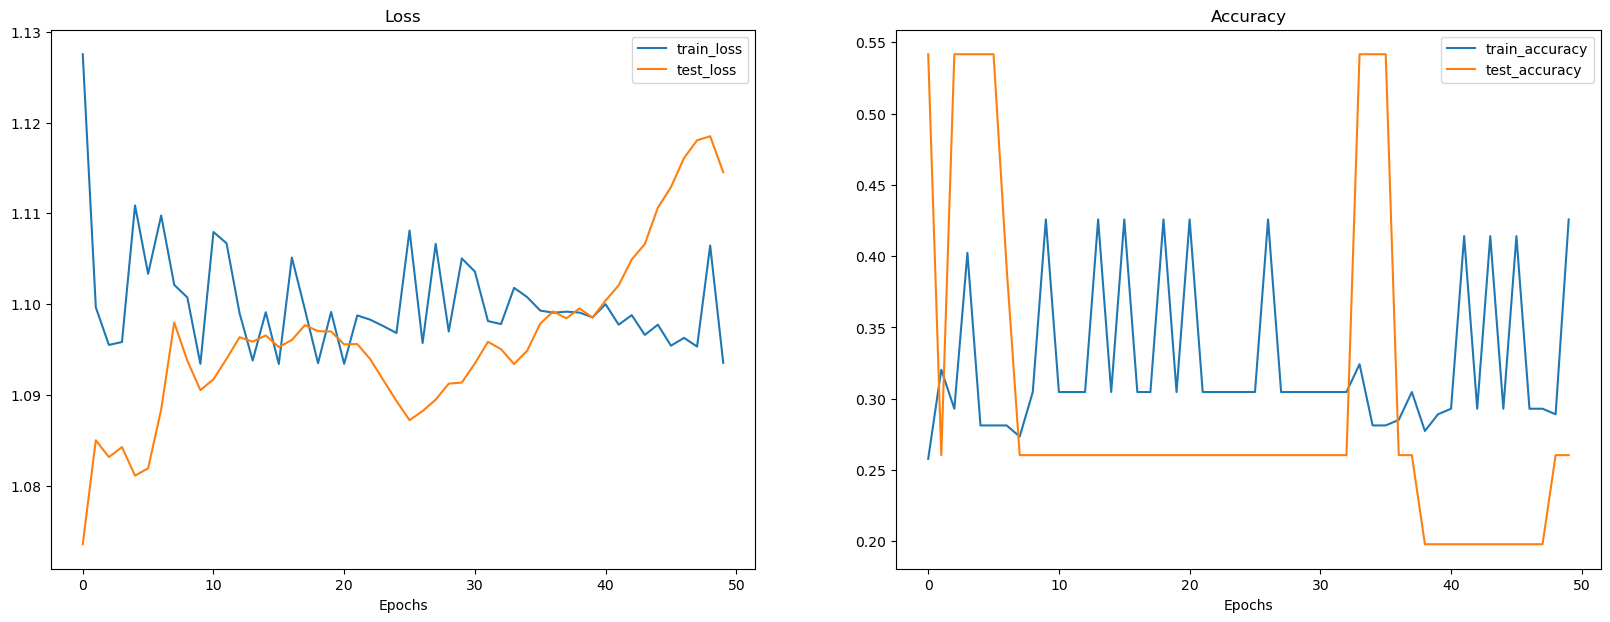

In [70]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots the training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    # Get the accuracy values of the results dicitonary (training and test)
    acc = results['train_acc']
    test_acc = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup the plot
    plt.figure(figsize=(20,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label= "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label = "train_accuracy")
    plt.plot(epochs, test_acc, label= "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before but with some data augmentation.

### 9.1 Create transform with data augmentation

In [71]:
# Create transform with data augmentation
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (256,256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

### Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [72]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root= train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)

In [73]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0 # os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

### 9.3 Construct and train model_1

This time we will be using the same model architecture except this time we've augmented the training data.

In [74]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGGModelV0(input_shape=3,
                         hidden_units=64,
                         output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGGModelV0(
  (conv_stack_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
 

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon out `train()` funciton to train and evaluate our model

In [75]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader= train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training itme for model_1: {end_time - start_time:.3f} seconds.")

  0%|          | 0/50 [00:00<?, ?it/s]

Training Loss: 1.10501 | Training Accuracy: 0.40625


  2%|▏         | 1/50 [00:32<26:26, 32.39s/it]

Testing Loss: 1.15099 | Testing Accuracy: 0.26042
Epoch: 0 | Train Loss: 1.105013 | Train Accuracy: 0.4062 | Test Loss: 1.1510 | Test Accuracy: 0.2604
Training Loss: 1.09338 | Training Accuracy: 0.42578


  4%|▍         | 2/50 [01:04<25:52, 32.34s/it]

Testing Loss: 1.10626 | Testing Accuracy: 0.26042
Epoch: 1 | Train Loss: 1.093378 | Train Accuracy: 0.4258 | Test Loss: 1.1063 | Test Accuracy: 0.2604
Training Loss: 1.11944 | Training Accuracy: 0.30469


  6%|▌         | 3/50 [01:37<25:23, 32.40s/it]

Testing Loss: 1.10867 | Testing Accuracy: 0.26042
Epoch: 2 | Train Loss: 1.119442 | Train Accuracy: 0.3047 | Test Loss: 1.1087 | Test Accuracy: 0.2604
Training Loss: 1.09283 | Training Accuracy: 0.42578


  8%|▊         | 4/50 [02:09<24:47, 32.33s/it]

Testing Loss: 1.08997 | Testing Accuracy: 0.26042
Epoch: 3 | Train Loss: 1.092827 | Train Accuracy: 0.4258 | Test Loss: 1.0900 | Test Accuracy: 0.2604
Training Loss: 1.10124 | Training Accuracy: 0.30469


 10%|█         | 5/50 [02:42<24:30, 32.68s/it]

Testing Loss: 1.09429 | Testing Accuracy: 0.26042
Epoch: 4 | Train Loss: 1.101243 | Train Accuracy: 0.3047 | Test Loss: 1.0943 | Test Accuracy: 0.2604
Training Loss: 1.09638 | Training Accuracy: 0.42578


 12%|█▏        | 6/50 [03:16<24:08, 32.93s/it]

Testing Loss: 1.08279 | Testing Accuracy: 0.26042
Epoch: 5 | Train Loss: 1.096380 | Train Accuracy: 0.4258 | Test Loss: 1.0828 | Test Accuracy: 0.2604
Training Loss: 1.09426 | Training Accuracy: 0.42578


 14%|█▍        | 7/50 [03:48<23:26, 32.72s/it]

Testing Loss: 1.08340 | Testing Accuracy: 0.26042
Epoch: 6 | Train Loss: 1.094264 | Train Accuracy: 0.4258 | Test Loss: 1.0834 | Test Accuracy: 0.2604
Training Loss: 1.09322 | Training Accuracy: 0.42578


 16%|█▌        | 8/50 [04:20<22:48, 32.57s/it]

Testing Loss: 1.08467 | Testing Accuracy: 0.26042
Epoch: 7 | Train Loss: 1.093220 | Train Accuracy: 0.4258 | Test Loss: 1.0847 | Test Accuracy: 0.2604
Training Loss: 1.11482 | Training Accuracy: 0.30469


 18%|█▊        | 9/50 [04:52<22:11, 32.49s/it]

Testing Loss: 1.08714 | Testing Accuracy: 0.26042
Epoch: 8 | Train Loss: 1.114825 | Train Accuracy: 0.3047 | Test Loss: 1.0871 | Test Accuracy: 0.2604
Training Loss: 1.09217 | Training Accuracy: 0.42578


 20%|██        | 10/50 [05:25<21:37, 32.44s/it]

Testing Loss: 1.08980 | Testing Accuracy: 0.26042
Epoch: 9 | Train Loss: 1.092173 | Train Accuracy: 0.4258 | Test Loss: 1.0898 | Test Accuracy: 0.2604
Training Loss: 1.09875 | Training Accuracy: 0.30469


 22%|██▏       | 11/50 [05:57<21:02, 32.37s/it]

Testing Loss: 1.09207 | Testing Accuracy: 0.26042
Epoch: 10 | Train Loss: 1.098752 | Train Accuracy: 0.3047 | Test Loss: 1.0921 | Test Accuracy: 0.2604
Training Loss: 1.09194 | Training Accuracy: 0.42578


 24%|██▍       | 12/50 [06:30<20:33, 32.45s/it]

Testing Loss: 1.09108 | Testing Accuracy: 0.26042
Epoch: 11 | Train Loss: 1.091941 | Train Accuracy: 0.4258 | Test Loss: 1.0911 | Test Accuracy: 0.2604
Training Loss: 1.09142 | Training Accuracy: 0.42578


 26%|██▌       | 13/50 [07:02<19:59, 32.41s/it]

Testing Loss: 1.09286 | Testing Accuracy: 0.26042
Epoch: 12 | Train Loss: 1.091423 | Train Accuracy: 0.4258 | Test Loss: 1.0929 | Test Accuracy: 0.2604
Training Loss: 1.09973 | Training Accuracy: 0.30469


 28%|██▊       | 14/50 [07:35<19:34, 32.63s/it]

Testing Loss: 1.09473 | Testing Accuracy: 0.26042
Epoch: 13 | Train Loss: 1.099728 | Train Accuracy: 0.3047 | Test Loss: 1.0947 | Test Accuracy: 0.2604
Training Loss: 1.11017 | Training Accuracy: 0.30469


 30%|███       | 15/50 [08:07<18:59, 32.55s/it]

Testing Loss: 1.09360 | Testing Accuracy: 0.26042
Epoch: 14 | Train Loss: 1.110169 | Train Accuracy: 0.3047 | Test Loss: 1.0936 | Test Accuracy: 0.2604
Training Loss: 1.09924 | Training Accuracy: 0.30469


 32%|███▏      | 16/50 [08:40<18:23, 32.46s/it]

Testing Loss: 1.09414 | Testing Accuracy: 0.26042
Epoch: 15 | Train Loss: 1.099241 | Train Accuracy: 0.3047 | Test Loss: 1.0941 | Test Accuracy: 0.2604
Training Loss: 1.09201 | Training Accuracy: 0.42578


 34%|███▍      | 17/50 [09:12<17:51, 32.46s/it]

Testing Loss: 1.09277 | Testing Accuracy: 0.26042
Epoch: 16 | Train Loss: 1.092009 | Train Accuracy: 0.4258 | Test Loss: 1.0928 | Test Accuracy: 0.2604
Training Loss: 1.09867 | Training Accuracy: 0.30469


 36%|███▌      | 18/50 [09:45<17:18, 32.45s/it]

Testing Loss: 1.09284 | Testing Accuracy: 0.26042
Epoch: 17 | Train Loss: 1.098671 | Train Accuracy: 0.3047 | Test Loss: 1.0928 | Test Accuracy: 0.2604
Training Loss: 1.09204 | Training Accuracy: 0.42578


 38%|███▊      | 19/50 [10:17<16:47, 32.51s/it]

Testing Loss: 1.09166 | Testing Accuracy: 0.26042
Epoch: 18 | Train Loss: 1.092043 | Train Accuracy: 0.4258 | Test Loss: 1.0917 | Test Accuracy: 0.2604
Training Loss: 1.10936 | Training Accuracy: 0.30469


 40%|████      | 20/50 [10:50<16:13, 32.44s/it]

Testing Loss: 1.09259 | Testing Accuracy: 0.26042
Epoch: 19 | Train Loss: 1.109356 | Train Accuracy: 0.3047 | Test Loss: 1.0926 | Test Accuracy: 0.2604
Training Loss: 1.09880 | Training Accuracy: 0.30469


 42%|████▏     | 21/50 [11:22<15:40, 32.44s/it]

Testing Loss: 1.09374 | Testing Accuracy: 0.26042
Epoch: 20 | Train Loss: 1.098799 | Train Accuracy: 0.3047 | Test Loss: 1.0937 | Test Accuracy: 0.2604
Training Loss: 1.09222 | Training Accuracy: 0.42578


 44%|████▍     | 22/50 [11:54<15:06, 32.39s/it]

Testing Loss: 1.09326 | Testing Accuracy: 0.26042
Epoch: 21 | Train Loss: 1.092222 | Train Accuracy: 0.4258 | Test Loss: 1.0933 | Test Accuracy: 0.2604
Training Loss: 1.09194 | Training Accuracy: 0.42578


 46%|████▌     | 23/50 [12:27<14:36, 32.45s/it]

Testing Loss: 1.09403 | Testing Accuracy: 0.26042
Epoch: 22 | Train Loss: 1.091935 | Train Accuracy: 0.4258 | Test Loss: 1.0940 | Test Accuracy: 0.2604
Training Loss: 1.09947 | Training Accuracy: 0.30469


 48%|████▊     | 24/50 [13:00<14:06, 32.55s/it]

Testing Loss: 1.09527 | Testing Accuracy: 0.26042
Epoch: 23 | Train Loss: 1.099471 | Train Accuracy: 0.3047 | Test Loss: 1.0953 | Test Accuracy: 0.2604
Training Loss: 1.10853 | Training Accuracy: 0.30469


 50%|█████     | 25/50 [13:32<13:31, 32.48s/it]

Testing Loss: 1.09462 | Testing Accuracy: 0.26042
Epoch: 24 | Train Loss: 1.108525 | Train Accuracy: 0.3047 | Test Loss: 1.0946 | Test Accuracy: 0.2604
Training Loss: 1.10728 | Training Accuracy: 0.30469


 52%|█████▏    | 26/50 [14:04<12:57, 32.38s/it]

Testing Loss: 1.09579 | Testing Accuracy: 0.26042
Epoch: 25 | Train Loss: 1.107278 | Train Accuracy: 0.3047 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.10516 | Training Accuracy: 0.30469


 54%|█████▍    | 27/50 [14:36<12:24, 32.35s/it]

Testing Loss: 1.09768 | Testing Accuracy: 0.26042
Epoch: 26 | Train Loss: 1.105160 | Train Accuracy: 0.3047 | Test Loss: 1.0977 | Test Accuracy: 0.2604
Training Loss: 1.10282 | Training Accuracy: 0.30469


 56%|█████▌    | 28/50 [15:09<11:51, 32.34s/it]

Testing Loss: 1.10012 | Testing Accuracy: 0.26042
Epoch: 27 | Train Loss: 1.102818 | Train Accuracy: 0.3047 | Test Loss: 1.1001 | Test Accuracy: 0.2604
Training Loss: 1.10069 | Training Accuracy: 0.30469


 58%|█████▊    | 29/50 [15:41<11:20, 32.39s/it]

Testing Loss: 1.10283 | Testing Accuracy: 0.26042
Epoch: 28 | Train Loss: 1.100693 | Train Accuracy: 0.3047 | Test Loss: 1.1028 | Test Accuracy: 0.2604
Training Loss: 1.09504 | Training Accuracy: 0.42578


 60%|██████    | 30/50 [16:13<10:47, 32.36s/it]

Testing Loss: 1.10202 | Testing Accuracy: 0.26042
Epoch: 29 | Train Loss: 1.095041 | Train Accuracy: 0.4258 | Test Loss: 1.1020 | Test Accuracy: 0.2604
Training Loss: 1.10055 | Training Accuracy: 0.30469


 62%|██████▏   | 31/50 [16:46<10:17, 32.48s/it]

Testing Loss: 1.10217 | Testing Accuracy: 0.26042
Epoch: 30 | Train Loss: 1.100549 | Train Accuracy: 0.3047 | Test Loss: 1.1022 | Test Accuracy: 0.2604
Training Loss: 1.09968 | Training Accuracy: 0.30469


 64%|██████▍   | 32/50 [17:19<09:44, 32.48s/it]

Testing Loss: 1.10018 | Testing Accuracy: 0.26042
Epoch: 31 | Train Loss: 1.099679 | Train Accuracy: 0.3047 | Test Loss: 1.1002 | Test Accuracy: 0.2604
Training Loss: 1.09879 | Training Accuracy: 0.30469


 66%|██████▌   | 33/50 [17:52<09:14, 32.60s/it]

Testing Loss: 1.09714 | Testing Accuracy: 0.26042
Epoch: 32 | Train Loss: 1.098795 | Train Accuracy: 0.3047 | Test Loss: 1.0971 | Test Accuracy: 0.2604
Training Loss: 1.10231 | Training Accuracy: 0.30469


 68%|██████▊   | 34/50 [18:24<08:40, 32.51s/it]

Testing Loss: 1.09535 | Testing Accuracy: 0.26042
Epoch: 33 | Train Loss: 1.102307 | Train Accuracy: 0.3047 | Test Loss: 1.0954 | Test Accuracy: 0.2604
Training Loss: 1.09622 | Training Accuracy: 0.42578


 70%|███████   | 35/50 [18:57<08:08, 32.56s/it]

Testing Loss: 1.09566 | Testing Accuracy: 0.26042
Epoch: 34 | Train Loss: 1.096216 | Train Accuracy: 0.4258 | Test Loss: 1.0957 | Test Accuracy: 0.2604
Training Loss: 1.09843 | Training Accuracy: 0.30469


 72%|███████▏  | 36/50 [19:29<07:34, 32.49s/it]

Testing Loss: 1.09647 | Testing Accuracy: 0.26042
Epoch: 35 | Train Loss: 1.098428 | Train Accuracy: 0.3047 | Test Loss: 1.0965 | Test Accuracy: 0.2604
Training Loss: 1.09567 | Training Accuracy: 0.42578


 74%|███████▍  | 37/50 [20:01<07:01, 32.42s/it]

Testing Loss: 1.09545 | Testing Accuracy: 0.26042
Epoch: 36 | Train Loss: 1.095669 | Train Accuracy: 0.4258 | Test Loss: 1.0954 | Test Accuracy: 0.2604
Training Loss: 1.09483 | Training Accuracy: 0.42578


 76%|███████▌  | 38/50 [20:33<06:28, 32.39s/it]

Testing Loss: 1.09580 | Testing Accuracy: 0.26042
Epoch: 37 | Train Loss: 1.094834 | Train Accuracy: 0.4258 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.09872 | Training Accuracy: 0.30469


 78%|███████▊  | 39/50 [21:06<05:56, 32.39s/it]

Testing Loss: 1.09640 | Testing Accuracy: 0.26042
Epoch: 38 | Train Loss: 1.098722 | Train Accuracy: 0.3047 | Test Loss: 1.0964 | Test Accuracy: 0.2604
Training Loss: 1.10437 | Training Accuracy: 0.30469


 80%|████████  | 40/50 [21:39<05:24, 32.49s/it]

Testing Loss: 1.09581 | Testing Accuracy: 0.26042
Epoch: 39 | Train Loss: 1.104373 | Train Accuracy: 0.3047 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.09881 | Training Accuracy: 0.30469


 82%|████████▏ | 41/50 [22:11<04:52, 32.45s/it]

Testing Loss: 1.09648 | Testing Accuracy: 0.26042
Epoch: 40 | Train Loss: 1.098813 | Train Accuracy: 0.3047 | Test Loss: 1.0965 | Test Accuracy: 0.2604
Training Loss: 1.09822 | Training Accuracy: 0.30469


 84%|████████▍ | 42/50 [22:44<04:20, 32.62s/it]

Testing Loss: 1.09531 | Testing Accuracy: 0.26042
Epoch: 41 | Train Loss: 1.098224 | Train Accuracy: 0.3047 | Test Loss: 1.0953 | Test Accuracy: 0.2604
Training Loss: 1.09515 | Training Accuracy: 0.42578


 86%|████████▌ | 43/50 [23:16<03:47, 32.50s/it]

Testing Loss: 1.09381 | Testing Accuracy: 0.26042
Epoch: 42 | Train Loss: 1.095155 | Train Accuracy: 0.4258 | Test Loss: 1.0938 | Test Accuracy: 0.2604
Training Loss: 1.10435 | Training Accuracy: 0.30469


 88%|████████▊ | 44/50 [23:49<03:14, 32.46s/it]

Testing Loss: 1.09385 | Testing Accuracy: 0.26042
Epoch: 43 | Train Loss: 1.104353 | Train Accuracy: 0.3047 | Test Loss: 1.0939 | Test Accuracy: 0.2604
Training Loss: 1.09484 | Training Accuracy: 0.42578


 90%|█████████ | 45/50 [24:21<02:41, 32.39s/it]

Testing Loss: 1.09566 | Testing Accuracy: 0.26042
Epoch: 44 | Train Loss: 1.094843 | Train Accuracy: 0.4258 | Test Loss: 1.0957 | Test Accuracy: 0.2604
Training Loss: 1.09896 | Training Accuracy: 0.30469


 92%|█████████▏| 46/50 [24:53<02:09, 32.31s/it]

Testing Loss: 1.09696 | Testing Accuracy: 0.26042
Epoch: 45 | Train Loss: 1.098962 | Train Accuracy: 0.3047 | Test Loss: 1.0970 | Test Accuracy: 0.2604
Training Loss: 1.09849 | Training Accuracy: 0.30469


 94%|█████████▍| 47/50 [25:25<01:36, 32.31s/it]

Testing Loss: 1.09578 | Testing Accuracy: 0.26042
Epoch: 46 | Train Loss: 1.098491 | Train Accuracy: 0.3047 | Test Loss: 1.0958 | Test Accuracy: 0.2604
Training Loss: 1.09470 | Training Accuracy: 0.42578


 96%|█████████▌| 48/50 [25:58<01:04, 32.39s/it]

Testing Loss: 1.09399 | Testing Accuracy: 0.26042
Epoch: 47 | Train Loss: 1.094703 | Train Accuracy: 0.4258 | Test Loss: 1.0940 | Test Accuracy: 0.2604
Training Loss: 1.09803 | Training Accuracy: 0.30469


 98%|█████████▊| 49/50 [26:30<00:32, 32.50s/it]

Testing Loss: 1.09411 | Testing Accuracy: 0.26042
Epoch: 48 | Train Loss: 1.098035 | Train Accuracy: 0.3047 | Test Loss: 1.0941 | Test Accuracy: 0.2604
Training Loss: 1.10534 | Training Accuracy: 0.30469


100%|██████████| 50/50 [27:03<00:00, 32.47s/it]

Testing Loss: 1.09298 | Testing Accuracy: 0.26042
Epoch: 49 | Train Loss: 1.105335 | Train Accuracy: 0.3047 | Test Loss: 1.0930 | Test Accuracy: 0.2604
Total training itme for model_1: 1623.516 seconds.


In [76]:
model_1_results

{'train_loss': [1.1050130277872086,
  1.0933775752782822,
  1.1194419413805008,
  1.0928265005350113,
  1.1012434214353561,
  1.096379593014717,
  1.0942636579275131,
  1.0932199656963348,
  1.1148245185613632,
  1.0921728610992432,
  1.098752349615097,
  1.0919407308101654,
  1.091422900557518,
  1.0997278839349747,
  1.1101688295602798,
  1.0992405116558075,
  1.0920085608959198,
  1.0986714959144592,
  1.0920428186655045,
  1.1093562692403793,
  1.0987987965345383,
  1.092221587896347,
  1.091935157775879,
  1.0994713455438614,
  1.1085250973701477,
  1.1072781533002853,
  1.105160415172577,
  1.1028183549642563,
  1.1006933450698853,
  1.0950407683849335,
  1.1005490720272064,
  1.0996785312891006,
  1.0987949818372726,
  1.1023072600364685,
  1.0962163656949997,
  1.0984282046556473,
  1.0956688225269318,
  1.0948342680931091,
  1.0987216532230377,
  1.1043725460767746,
  1.0988128036260605,
  1.0982235819101334,
  1.0951548963785172,
  1.1043527275323868,
  1.094843327999115,
  1

### 9.4 Plot the loss curves of model_1

A loss curve helps you evaluate your models performance overtime.

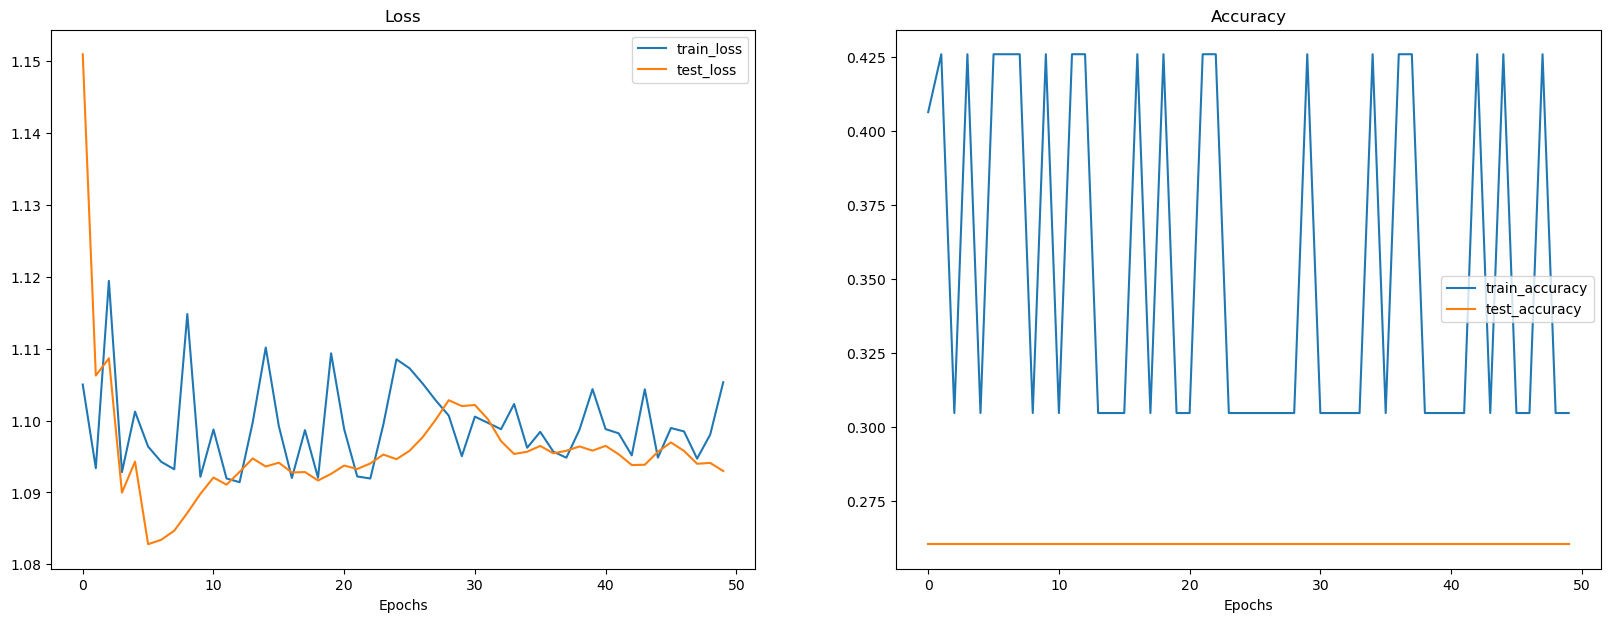

In [77]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it is important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we are doing)
2. PyTorch TensorBoard
3. Weights and Biases
4. MLFlow

In [78]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

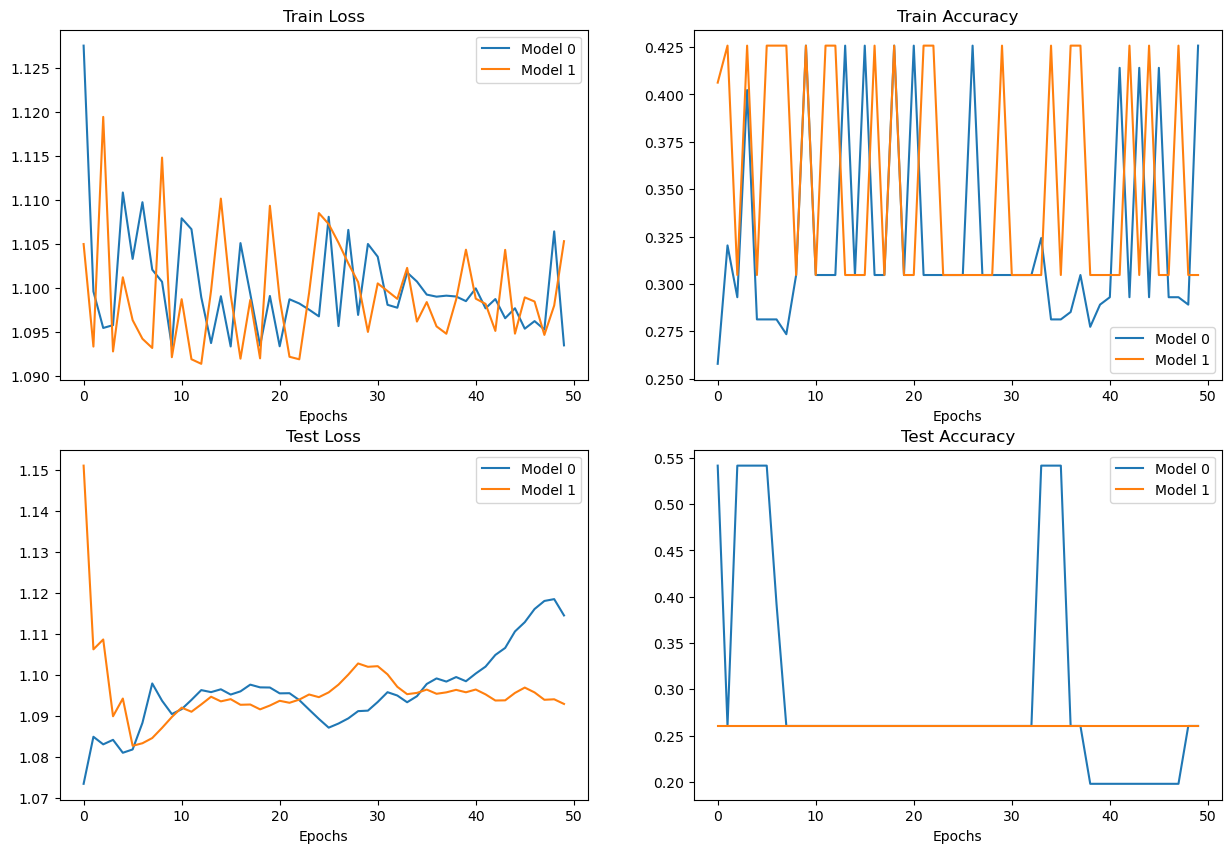

In [79]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label= "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['train_acc'], label= "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['test_loss'], label= "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label= "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [80]:
# Download custom Image
import requests

# Setup custom image path
custom_image_path = data_path/ "pizza.jpeg"

# Download the image if it does not already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # Whe downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://recipesblob.oetker.in/assets/d8a4b00c292a43adbb9f96798e028f01/1272x764/pizza-pollo-arrostojpg.jpg")
        print(f"Downloading {custom_image_path}....")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

food_data\pizza.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image in the same format as the data our model was trained on.
* In tensor form with the datatype (torch.float32)
* Of shape 64 x 64 x 3
* On the right device

In [81]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")


Custom image tensor: 
 tensor([[[246, 251, 255,  ..., 249, 240, 234],
         [246, 251, 255,  ..., 247, 238, 232],
         [245, 251, 255,  ..., 245, 236, 231],
         ...,
         [224, 227, 233,  ..., 242, 233, 228],
         [218, 222, 227,  ..., 244, 235, 230],
         [214, 218, 224,  ..., 246, 236, 231]],

        [[236, 241, 250,  ..., 217, 208, 202],
         [236, 241, 250,  ..., 215, 206, 200],
         [235, 241, 250,  ..., 211, 202, 197],
         ...,
         [189, 192, 198,  ..., 211, 202, 197],
         [181, 185, 192,  ..., 213, 204, 199],
         [177, 181, 189,  ..., 215, 205, 200]],

        [[224, 229, 238,  ..., 179, 170, 164],
         [224, 229, 238,  ..., 177, 168, 162],
         [223, 229, 238,  ..., 174, 165, 160],
         ...,
         [149, 152, 160,  ..., 164, 156, 151],
         [139, 143, 152,  ..., 167, 158, 153],
         [133, 137, 147,  ..., 169, 159, 154]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 764, 1272])
Custom image data

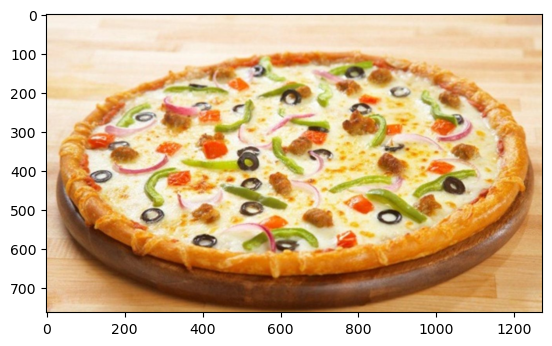

In [82]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

# Try to make a prediction on an image in uint8 format
# This will give an error

model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

tensor([[[0.9647, 0.9843, 1.0000,  ..., 0.9765, 0.9412, 0.9176],
         [0.9647, 0.9843, 1.0000,  ..., 0.9686, 0.9333, 0.9098],
         [0.9608, 0.9843, 1.0000,  ..., 0.9608, 0.9255, 0.9059],
         ...,
         [0.8784, 0.8902, 0.9137,  ..., 0.9490, 0.9137, 0.8941],
         [0.8549, 0.8706, 0.8902,  ..., 0.9569, 0.9216, 0.9020],
         [0.8392, 0.8549, 0.8784,  ..., 0.9647, 0.9255, 0.9059]],

        [[0.9255, 0.9451, 0.9804,  ..., 0.8510, 0.8157, 0.7922],
         [0.9255, 0.9451, 0.9804,  ..., 0.8431, 0.8078, 0.7843],
         [0.9216, 0.9451, 0.9804,  ..., 0.8275, 0.7922, 0.7725],
         ...,
         [0.7412, 0.7529, 0.7765,  ..., 0.8275, 0.7922, 0.7725],
         [0.7098, 0.7255, 0.7529,  ..., 0.8353, 0.8000, 0.7804],
         [0.6941, 0.7098, 0.7412,  ..., 0.8431, 0.8039, 0.7843]],

        [[0.8784, 0.8980, 0.9333,  ..., 0.7020, 0.6667, 0.6431],
         [0.8784, 0.8980, 0.9333,  ..., 0.6941, 0.6588, 0.6353],
         [0.8745, 0.8980, 0.9333,  ..., 0.6824, 0.6471, 0.

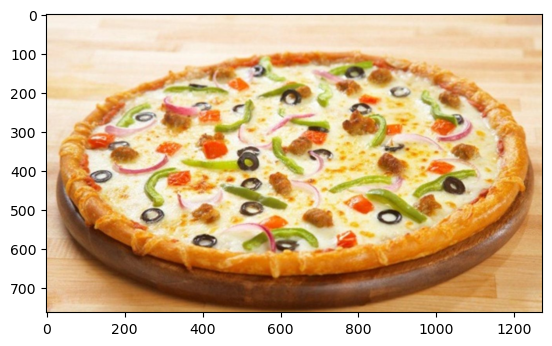

In [83]:
# Load in the custom image and convert to torch.float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
plt.imshow(custom_image.permute(1,2,0))
custom_image

Original shape: torch.Size([3, 764, 1272])
Transformed shape: torch.Size([3, 256, 256])


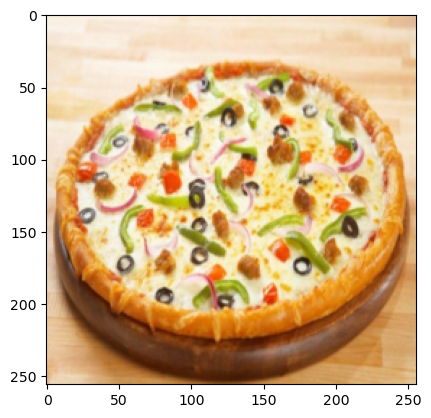

In [84]:
# Create transform pipeline to resize image
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size = (256,256))
])

# Transform the target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

# Visualize the image
plt.imshow(custom_image_transformed.permute(1,2,0))

Now, in order to predict the class of the image, we will also need to move the data to the target device. (Which is "cuda" in this case.)
After that, we will also need to add an extra dimension(unsqueeze at zeroth dimension) to the data because the model accepts the data in the form of batches, hence the input tensor to the model while training is an extra dimension.

In [85]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim = 0).to(device))

custom_image_pred

tensor([[ 0.0591, -0.0307,  0.0311]], device='cuda:0')

Note, to make a prediciton on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on `(3, 256, 256)` with a batch size .... `(1, 3, 256, 256)`
* Make sure the image was on the same device as our model

In [86]:
# Convert logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.3464, 0.3167, 0.3369]], device='cuda:0')

In [87]:
# Convert prediciton probabilities to prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim =1).cpu()
custom_image_pred_labels

tensor([0])

In [88]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [89]:
import torchvision

def predict_label_and_plot_image(image_path,
                                 class_names: List[str] = None,
                                 transform = None,
                                 model : torch.nn.Module = model_1,
                                 device = device):
    
    """Makes a prediciton on a target image with a trained model and plots the image and prediction."""
    # Load the image in the correct datatype and normalise the values (divide it by 255) 
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)/255

    # If necessary, transform the custom image into appropriate size for the trained model 
    if transform:
        custom_image_transformed = transform(custom_image)
    else:
        custom_image_transformed = custom_image

    # Add an extra dimention to the image and move the image to target device
    custom_image_transformed = custom_image_transformed.unsqueeze(dim =0).to(device) # Unsqueeze is needed on dim = 0 because the model accepted training data in the form of batches which had an extra dimension.
    
    # Move the model to the device
    model.to(device)

    # Set the model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # Do the forward pass to obtain logits
        custom_image_pred_logits = model(custom_image_transformed)

    # Calculate the predition probilities using the logits
    custom_image_pred_probs = torch.softmax(custom_image_pred_logits, dim = 1)

    # Obtain the class in numeric for using the pred probabilities
    custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1).cpu()

    # Plotting the image and the image class as its title
    plt.figure(figsize = (20,14))
    plt.imshow(custom_image.permute(1,2,0).numpy()) # permute is necessary to convert the image to matplotlib friendly dimension. Matplotlib only acepts numpy arrays.
    
    # Obtain the class of the image
    if class_names:
        title = f"Pred: {class_names[custom_image_pred_labels.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {custom_image_pred_labels} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
        
    plt.title(title, fontsize = 20)
    plt.axis(False)

In [90]:
custom_image_path

WindowsPath('food_data/pizza.jpeg')

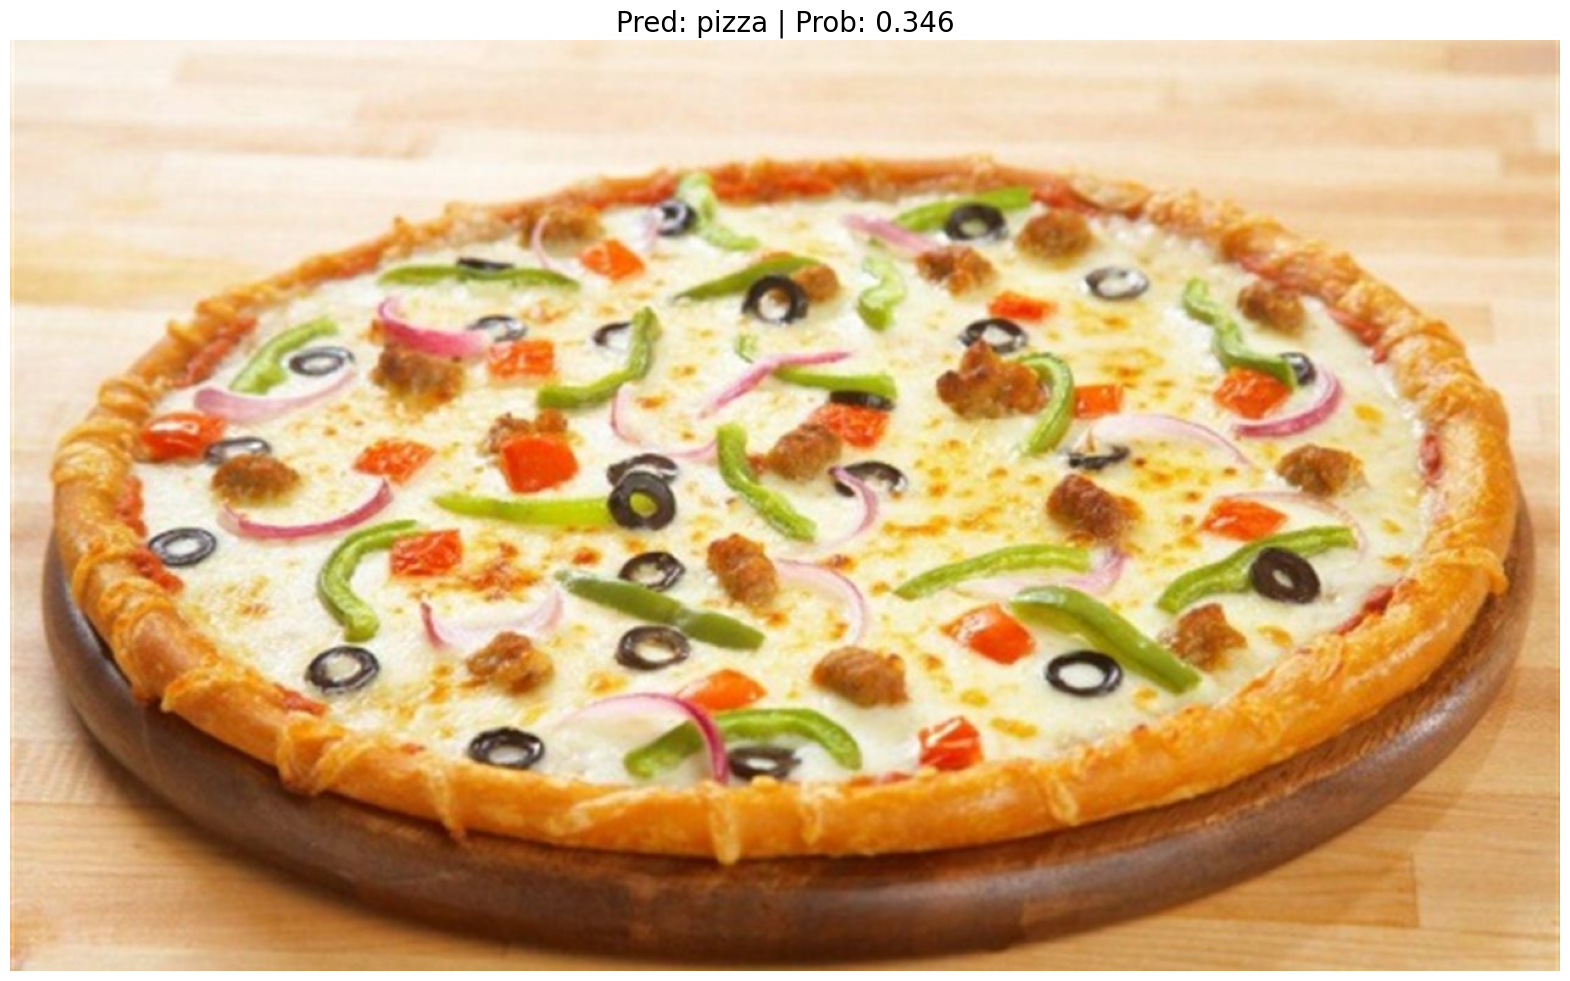

In [91]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(size=(256,256))
])

predict_label_and_plot_image(custom_image_path,transform=transform,class_names=class_names, model=model_1)